In [12]:
import numpy as np
import torch 
import torchvision 
import torchaudio
import torch.nn as nn
import math
import torch.nn.functional as F
from Jaguas_DataLoader import SoundscapeData
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import random_split
!pip install positional-encodings[pytorch]
from positional_encodings.torch_encodings import PositionalEncoding1D, PositionalEncoding2D, PositionalEncoding3D, Summer, PositionalEncodingPermute2D
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!pip install wandb --upgrade
!wandb login
import wandb
from IPython.display import clear_output
import datetime
wandb.login()

wandb: Currently logged in as: danielnieto. Use `wandb login --relogin` to force relogin


True

In [13]:
class PositionalEncoding2d(nn.Module):

    def __init__(self, d_model: int=64, height: int = 9, width: int =9, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(d_model, height, width)
        # Each dimension use half of d_model
        d_model = int(d_model / 2)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pos_w = torch.arange(0., width).unsqueeze(1)
        pos_h = torch.arange(0., height).unsqueeze(1)
        pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        self.register_buffer('pe', pe)
        
    def forward(self, x, index: int, dropout: bool=False):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x.to("cuda")
        self.pe = self.pe.to("cuda")
#         print(x.shape, self.pe.shape)
        x = x + self.pe[index]
        if dropout:
            x = self.dropout(x)
        else:
            x = x
        return x

In [14]:
class posautoencoding_m1(nn.Module):

    """
    Convolutional autoencoder made to reconstruct the audios spectrograms generated by the EcoDataTesis dataloader.
    """

    def __init__(self, num_hiddens: int = 64):
        """
        Constructor of the convolutional autoencoder model.
        """
        super().__init__()
        # TODO: To design the final architechture considering the spectrograms sizes.
        # TODO: To correct the current sizes of the decoder.

        self.encoder = nn.Sequential(
            nn.Conv2d(1, num_hiddens // 8, kernel_size=8, stride=3, padding=0),  # N, 256, 127, 8004
            nn.ReLU(),
            nn.Conv2d(num_hiddens // 8, num_hiddens // 4, kernel_size=8, stride=3, padding=0),  # N, 512, 125,969
            nn.ReLU(),
            nn.Conv2d(num_hiddens // 4, num_hiddens // 2, kernel_size=4, stride=3, padding=0),  # N, 512, 125,969
            nn.ReLU(),
            nn.Conv2d(num_hiddens // 2, num_hiddens, kernel_size=2, stride=2, padding=0),  # N, 512, 125,969
            nn.ReLU()
             )
        self.decoder = nn.Sequential(  # This is like go in opposite direction respect the encoder
            nn.ConvTranspose2d(num_hiddens, num_hiddens // 2, kernel_size=2, stride=2, padding=0, output_padding=0),  # N, 32, 126,8000
            nn.ReLU(),
            nn.ConvTranspose2d(num_hiddens // 2, num_hiddens // 4, kernel_size=4, stride=3, padding=0, output_padding=0),  # N, 32, 127,64248
            nn.ReLU(),
            nn.ConvTranspose2d(num_hiddens // 4, num_hiddens // 8, kernel_size=8, stride=3, padding=0, output_padding=0),  # N, 32, 127,64248
            nn.ReLU(),
            nn.ConvTranspose2d(num_hiddens // 8, 1, kernel_size=8, stride=3, padding=0, output_padding=0),  # N, 32, 127,64248
            nn.Sigmoid()

            )
            
            
    def forward(self, x, y):
        
        """
        Method to compute an image output based on the performed model.

        :param x: Input spectrogram images as tensors.
        :type x: torch.tensor
        :return: Reconstructed images
        """
        
        #print(f"x_shape:{x.shape}")
        encoded = self.encoder(x)
#         print("encoded: ", encoded.shape)
        pos_encoder = PositionalEncoding2d(64, dropout = 0.1, max_len = 4).to("cuda")
        posencoding_2d = pos_encoder(encoded.permute(1,0,2,3), y)
#         print(posencoding_2d)
        posencoding_2d = posencoding_2d.permute(1,0,2,3)
#         print("encoder_shape: ", encoded.shape)
        decoded = self.decoder(posencoding_2d)
#         print("decoder_shape: ",decoded.shape)
        return decoded

In [15]:
root_path = 'media/mirp_ai/DATA1/Jaguas_2018'
dataset = SoundscapeData(root_path, audio_length=12, ext="wav", win_length=1028)
dataset_train, dataset_test = random_split(dataset,
                                           [round(len(dataset)*0.7), len(dataset) - round(len(dataset)*0.7)], 
                                           generator=torch.Generator().manual_seed(1024))

config = {
    "project" : "positionalAE-Jaguas",
    "audio_length": dataset.audio_length,
    "batch_size" : 14,
    "num_epochs": 10,
    "num_hiddens" : 64,
    "gamma_lr" : 0.1,
    "learning_rate" : 1e-3,
    "dataset" : "Audios Jaguas",
    "architecture": "PositionalAE",
    "win_length" : dataset.win_length
}

training_loader = DataLoader(dataset_train, batch_size=config["batch_size"])
test_loader = DataLoader(dataset_test, batch_size=config["batch_size"])

model = posautoencoding_m1(num_hiddens=config["num_hiddens"]).to("cuda")

optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], amsgrad=False)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 5, gamma = config["gamma_lr"] )

config["optimizer"] = optimizer
config["scheduler"] = scheduler
config["num_training_updates"] = len(training_loader)

/media/mirp_ai/DATA1/Jaguas_2018


In [16]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
class TestModel:
    """
            Class to test convolutional autoencoder models.

            :param index: index indicates the number of data to return.
            :returns:
                :spec: Spectrogram of the indexed audios.
                :type spec: torch.tensor
                :record: Array of indexed audios in monophonic format.
                :type record: numpy.array
                :label: Dictionary of labels including recorder, hour, minute and second keys.
                :type label: Dictionary
                :path_index: File directory.
                :type path index: String

    """

    def __init__(self, model, iterator, num_views=8, device="cuda"):

        """
            :param model: Deep learning model.
            :type model:
            :param iterator: dataloader iterator.
            :type iterator:
            :param num_views: Specify the number of samples to visualize previously and after the reconstruction.
            :type num_views:
            :param device: Specify the device to do calculus.
            :type device:
            Todo:
                Check the args type.
            """

        self._model = model
        self._iterator = iterator
        self.num_views = num_views
        self.device = device
        # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def save_waveform(self, waveform, directory=None):
        scaled = np.int16(waveform[0, 0] / np.max(np.abs(waveform[0, 0])) * 32767)
        write(directory + '.wav', 22050, scaled)

    def plot_waveform(self, waveform, n_rows=4):
        fig, axs = plt.subplots(n_rows, figsize=(10, 6), constrained_layout=True)
        for i in range(n_rows):
            axs[i].plot(waveform[i, 0])
        plt.show()

    def waveform_generator(self, spec, n_fft=1028, win_length=1028, audio_length=12, base_win=256):
        spec = spec.cdouble()
        spec = spec.to("cpu")
        # hop_length = int(np.round(base_win/win_length * 172.3))
        transformation = audio_transform.InverseSpectrogram(n_fft=n_fft, win_length=win_length)
        waveform = transformation(spec)
        waveform = waveform.cpu().detach().numpy()
        return waveform

    def plot_psd(self, waveform, n_wavs=1):
        for i in range(n_wavs):
            plt.psd(waveform[i][0])
            plt.xlabel("Frequency", fontsize=16)
            plt.ylabel("Power Spectral Density", fontsize=16)
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)

    def plot_reconstructions(self, imgs_original, imgs_reconstruction):
        output = torch.cat((imgs_original[0:self.num_views], imgs_reconstruction[0:self.num_views]), 0)
        img_grid = make_grid(output, nrow=self.num_views, pad_value=20)
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.imshow(img_grid[1, :, :].cpu(), origin="lower", vmin=0, vmax=1)
        ax.axis("off")
        plt.show()
        return fig

    def reconstruct(self):
        self._model.eval()
        (valid_originals, _, label, path) = next(self._iterator)
        valid_originals = torch.reshape(valid_originals, (valid_originals.shape[0] * valid_originals.shape[1]
                                                          * valid_originals.shape[2], valid_originals.shape[3],
                                                          valid_originals.shape[4]))
        valid_originals = torch.unsqueeze(valid_originals, 1)
        valid_originals = valid_originals.to(self.device)
        
        
        valid_encodings = self._model.encoder(valid_originals)
        pos_encoder = PositionalEncoding2d(64, dropout = 0.1, max_len = 4).to("cuda")
        posencoding_2d = pos_encoder(valid_encodings.permute(1,0,2,3), label["recorder"].reshape(valid_originals.shape[0]))
        valid_encodings = posencoding_2d.permute(1,0,2,3)

        valid_reconstructions = self._model.decoder(valid_encodings)

        valid_originals_nonorm = torch.expm1(valid_originals)
        valid_reconstructions_nonorm = torch.expm1(valid_reconstructions)

        BCE = F.mse_loss(valid_reconstructions, valid_originals)
        loss = BCE

        return valid_originals, valid_reconstructions, valid_encodings, label, loss, path

In [17]:
from six.moves import xrange
class TrainModel:

    def __init__(self, model):
        self._model = model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self._model.to(self.device)
        print(self.device)
        
    def wandb_init(self, config, keys=["batch_size", "num_hiddens"]):
        try:
            run_name = str(config["architecture"]+"_")
            for key in keys:
                if key in config.keys():
                    run_name = run_name + key + "_" + str(config[key]) + "_"
                else:
                    run_name = run_name + str(key)

            wandb.login()
            wandb.finish()
            wandb.init(project=config["project"], config=config)
            wandb.run.name = run_name
            wandb.run.save()
            wandb.watch(self._model, F.mse_loss, log="all", log_freq=1)
            is_wandb_enable = True
        except Exception as e:
            print(e)
            is_wandb_enable = False

        return is_wandb_enable, run_name

    def wandb_logging(self, dict):
        for keys in dict:
            wandb.log({keys: dict[keys]})
            

    def forward(self, training_loader, test_loader, config):
        iterator = iter(test_loader)
        wandb_enable, run_name = self.wandb_init(config)
        optimizer = config["optimizer"]
        scheduler = config["scheduler"]
        
        logs = []
        # best_loss = 10000

        for epoch in range(config["num_epochs"]):
            iterator_train = iter(training_loader)
            for i in xrange(config["num_training_updates"]):
                self._model.train()
                try:
                    data, _, label, _ = next(iterator_train)
                except Exception as e:
                    print("error")
                    print(e)
                    logs.append(e)
                    continue

                data = torch.reshape(data, (data.shape[0] * data.shape[1] * data.shape[2], data.shape[3], data.shape[4]))
                print(data.shape)
                data = torch.unsqueeze(data, 1)
                print(data.shape)
                data = data.to("cuda")

                optimizer.zero_grad()
                data_recon = self._model(data, label["recorder"].reshape(data.shape[0]))

                loss = F.mse_loss(data_recon, data)
                loss.backward()

                optimizer.step()
                print(
                    f'epoch: {epoch + 1} of {config["num_epochs"]} \t iteration: {(i + 1)} of {config["num_training_updates"]} \t loss: {np.round(loss.item(), 4)}')
                dict = {"loss": loss.item()}
                self.wandb_logging(dict)
                
                period = 200
                if (i + 1) % period == 0:
                    try:
                        test_ = TestModel(self._model, iterator, 8, device=torch.device("cuda"))
                        # torch.save(model.state_dict(),f'model_{epoch}_{i}.pkl')
                        originals, reconstructions, encodings, labels, test_error, path = test_.reconstruct()
                        fig = test_.plot_reconstructions(originals, reconstructions)
                        images = wandb.Image(fig, caption=f"recon_error: {np.round(test_error.item(), 4)}")
                        self.wandb_logging({"examples": images, "step": (i + 1) // period})

                    except Exception as e:
                        print(f"error; {e}")
                        logs.append(e)
                        continue
                else:
                    pass
                

            scheduler.step()
            torch.cuda.empty_cache()
            time = datetime.datetime.now()
            torch.save(self._model.state_dict(), f'{run_name}_day_{time.day}_hour_{time.hour}_epoch_{epoch + 1}.pkl')
            clear_output()
            print(optimizer.state_dict()["param_groups"][0]["lr"])

        wandb.finish()
        return self._model, logs, run_name

In [ ]:
Training = TrainModel(model=model.to("cuda"))
model, logs, run_name = Training.forward(training_loader, test_loader, config)
time = datetime.datetime.now()
torch.save(model.state_dict(),f'temporal/models/model_{run_name}_day_{time.day}_hour_{time.hour}_final.pth')
torch.save(config,f'temporal/configs/config_{run_name}_day_{time.day}_hour_{time.hour}.pth')
torch.save(dataset_test, f"temporal/datasets/dataset_test_posae_jaguas_{time.day}_70%.pth")
torch.save(dataset_train, f"temporal/datasets/dataset_train_posae_jaguas_{time.day}_70%.pth")

In [20]:
iterador = iter(training_loader)
data, b, c, d = next(iterador)
data = torch.reshape(data, (data.shape[0] * data.shape[1] *data.shape[2], data.shape[3], data.shape[4]))
data = torch.unsqueeze(data, 1)
data.shape

torch.Size([70, 1, 515, 515])

In [77]:
training_loader = DataLoader(dataset_train, batch_size=1)
test_loader = DataLoader(dataset_test, batch_size=2)
iterator = iter(test_loader)
testing = TestModel(model, iterator, device=torch.device("cuda"))

In [76]:
reconstructions[3]

tensor([[[0.9969, 0.9976, 0.9988,  ..., 0.9980, 0.9968, 0.9968],
         [0.9957, 0.9964, 0.9977,  ..., 0.9968, 0.9937, 0.9946],
         [0.2796, 0.2895, 0.2647,  ..., 0.2893, 0.2994, 0.2740],
         ...,
         [0.0157, 0.0134, 0.0022,  ..., 0.0117, 0.0209, 0.0183],
         [0.0316, 0.0230, 0.0095,  ..., 0.0124, 0.0272, 0.0274],
         [0.0761, 0.0646, 0.0322,  ..., 0.0422, 0.0687, 0.0728]]],
       device='cuda:0', grad_fn=<SelectBackward0>)

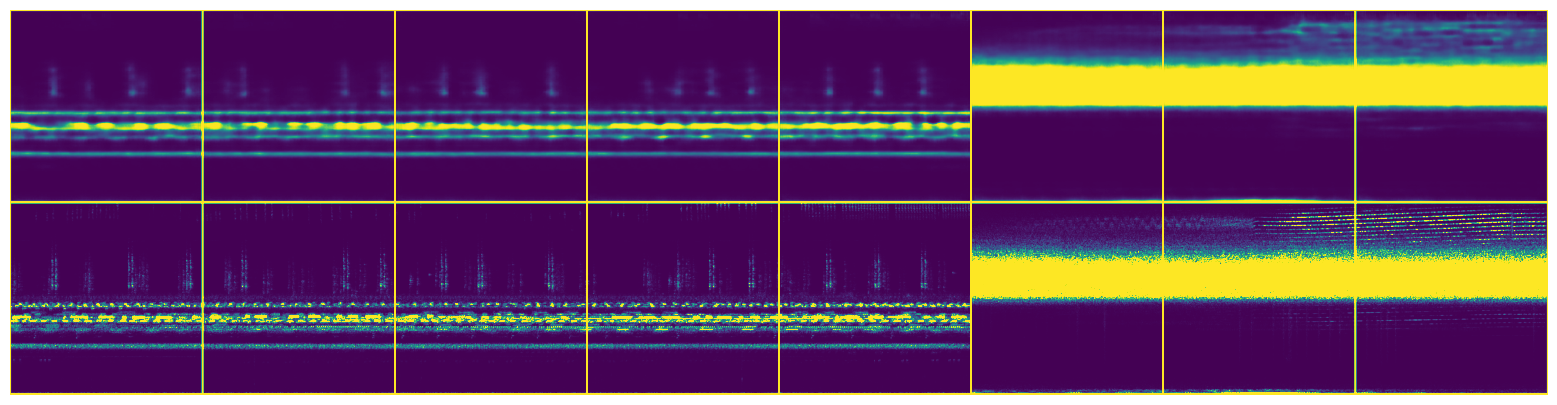

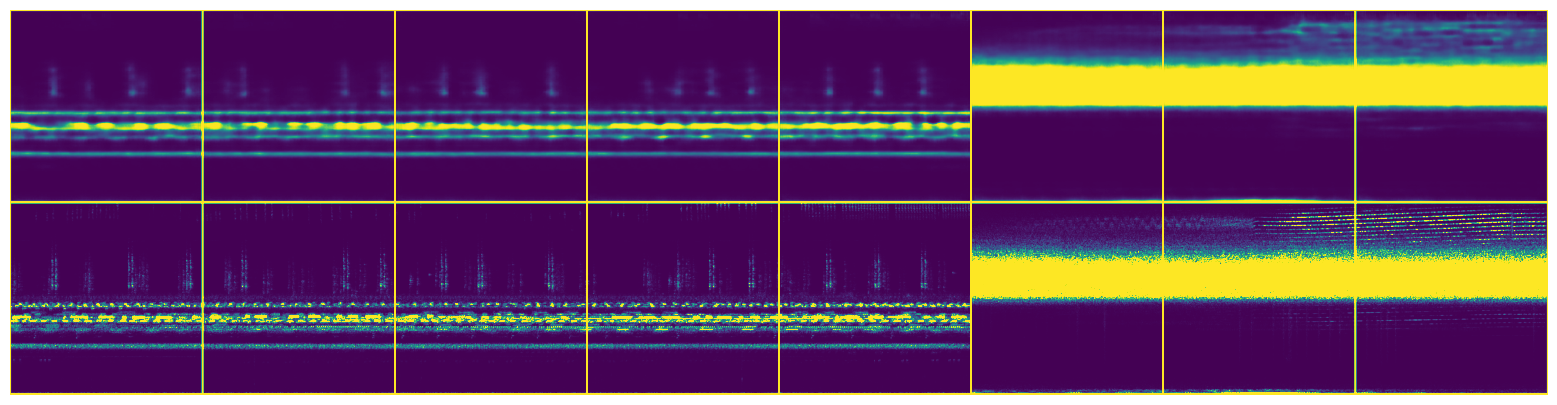

In [78]:
originals, reconstructions, encodings, loss, label, path = testing.reconstruct()
testing.plot_reconstructions(originals, reconstructions)

In [58]:
originals, reconstructions, encodings, loss, label, path = testing.reconstruct()

# Featurer

In [33]:
model_name = f"temporal/models/model_PositionalAE_batch_size_14_num_hiddens_64__day_22_hour_23_final.pth"
config = torch.load(f'temporal/configs/config_PositionalAE_batch_size_14_num_hiddens_64__day_22_hour_23.pth', map_location=torch.device('cpu'))
model = posautoencoding_m1(num_hiddens=config["num_hiddens"]).to("cuda")
dataset_test = torch.load(f'temporal/datasets/dataset_test_posae_jaguas_22_70%.pth')
dataset_train = torch.load(f'temporal/datasets/dataset_train_posae_jaguas_22_70%.pth')
model.load_state_dict(torch.load(f'{model_name}', map_location=torch.device('cpu')))

<All keys matched successfully>

In [80]:
from six.moves import xrange
training_loader = DataLoader(dataset_train, batch_size=1)
test_loader = DataLoader(dataset_test, batch_size=1)
iterator = iter(training_loader)
testing = TestModel(model, iterator, device=torch.device("cuda"))
encodings_size = encodings[0].shape

training_recorder_list = []
training_hour_list = []
training_minute_list = []
delete_samples = []
training_path_samples = []
training_samples_list_torch = []
for id in range(len(training_loader)):
#     if (id+1)%5 == 0:
#         print("finished")
#         break
    if (id+1)% 500 == 0:
        print(f"id: {id + 1} of {len(dataset_train)}")
    try:
        originals, reconstructions, encodings, label, loss, path = testing.reconstruct()
    except:
        print(f"error id: {id}")
        delete_samples.append(id)
        continue

    encodings_size = encodings[0].shape
    encodings = encodings.to("cuda").detach()
    encodings = encodings.reshape(encodings.shape[0],
                                encodings.shape[1]*encodings.shape[2]*encodings.shape[3])
    encoding = encodings.squeeze(dim=0)
    training_samples_list_torch.append(encodings)
    training_recorder_list.append(label["recorder"].reshape(label["recorder"].shape[0]*label["recorder"].shape[1]))
    training_hour_list.append(label["hour"].reshape(label["hour"].shape[0]*label["hour"].shape[1]))
    training_minute_list.append(label["minute"].reshape(label["minute"].shape[0]*label["minute"].shape[1]))
    
    
    path = np.asarray(path)
    path = np.repeat(path, 5)
    training_path_samples.append(path)

training_recorder_list = torch.cat(training_recorder_list,dim=0)
training_hour_list = torch.cat(training_hour_list,dim=0)
training_minute_list = torch.cat(training_minute_list,dim=0)
training_samples_list_torch = torch.cat(training_samples_list_torch, dim=0)

torch.save(training_path_samples, "Features/train_path_samples_posae.pth")
torch.save(training_samples_list_torch, "Features/train_samples_list_torch_70%_posae.pth")
torch.save(training_recorder_list, "Features/train_recorder_list_70%_posae.pth")
torch.save(training_hour_list, "Features/train_hour_list_70%_posae.pth")
torch.save(training_minute_list, "Features/train_minute_list_70%_posae.pth")
training_labels_list = {"recorder": training_recorder_list, "hour": training_hour_list, "minute": training_minute_list}
torch.save(training_labels_list, "Features/train_labels_list_70%_posae.pth")
torch.save(delete_samples, "Features/train_corrupted_samples_list_70%_posae.pth")

id: 500 of 14048
id: 1000 of 14048
id: 1500 of 14048
id: 2000 of 14048
id: 2500 of 14048
id: 3000 of 14048
id: 3500 of 14048
id: 4000 of 14048
id: 4500 of 14048
id: 5000 of 14048
id: 5500 of 14048
id: 6000 of 14048
id: 6500 of 14048
id: 7000 of 14048
id: 7500 of 14048
id: 8000 of 14048
id: 8500 of 14048
id: 9000 of 14048
id: 9500 of 14048
id: 10000 of 14048
id: 10500 of 14048
id: 11000 of 14048
id: 11500 of 14048
id: 12000 of 14048
id: 12500 of 14048
id: 13000 of 14048
id: 13500 of 14048
id: 14000 of 14048


In [ ]:
test = TestModel(model, iterador)

In [ ]:
posenc = PositionalEncoding2d() 
x = posenc(encodes.permute(1,0,2,3), c["recorder"].reshape(14*5))

In [ ]:
posenc = PositionalEncoding2d() 
encodes = model.encoder(data.to("cuda"))
print(encodes.shape)
posencoding_2d = posenc(data, c["recorder"].reshape(14*5))
decoded = model.decoder(posencoding_2d)
